# Linear Regression 
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')

#train_df = pd.read_csv('/Users/Jivan/Desktop/train.csv')
#test_df = pd.read_csv('/Users/Jivan/Desktop/test.csv')
#orig_df = pd.read_csv('/Users/Jivan/Desktop/train.csv')



In [2]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count

In [3]:
def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

train_df = normalize(train_df)
test_df = normalize(test_df)


In [4]:
pd.set_option('display.max_columns', None)
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,14000000,6.575393,93.0,12314651,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,24,3,1,2
1,40000000,8.248895,113.0,95149435,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,9,20,1,1,8
2,3300000,64.299990,105.0,13092000,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,64,51,3,1,10
3,1200000,3.174936,122.0,16000000,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,7,0,0,3
4,0,1.148070,118.0,3923970,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,2


In [5]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,2


In [6]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn import preprocessing

from sklearn import metrics

from sklearn.model_selection import cross_val_score



In [7]:
feature_cols = ['budget', 'popularity', 'runtime', 'language_count', 'produced_in_usa', 'prod_country_counted', 'Action', 
                'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 
                'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 
                'count_of_crew', 'count_of_cast', 'production_companies_count', 'orig_lang_is_eng', 'release_month']
X = train_df[feature_cols]
X = preprocessing.scale(X)



In [8]:
y = train_df['revenue']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2400, 31)
(2400,)
(600, 31)
(600,)


In [105]:
from sklearn.model_selection import GridSearchCV

# dictionary with parameters to test
params = {'n_jobs': [None, 1, 2, 5, 10, 100, 200, 500, 1000, 10000]}

# create regressor
my_linreg = LinearRegression()

# create grid
lr_grid = GridSearchCV(my_linreg,
                        params,
                        cv = 10,
                        scoring='neg_mean_squared_error',
                        verbose=True)

# fit the grid
lr_grid.fit(X_train, y_train)

# see results
print(lr_grid.best_score_)
print(lr_grid.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
-7897077678640790.0
{'n_jobs': None}


In [10]:
# instantiates classifier object
lr = LinearRegression(n_jobs=None)

# train the data set
lr.fit(X_train, y_train)

# seeing the intercept
print(lr.intercept_)

# seeing coefficients
print(lr.coef_)

66672221.137276866
[77551615.25496067 30312183.04836619 12096785.03661362  1837290.79973674
  5708161.74524337 -4304218.5828988   -347193.96536901 10018319.18925433
  5683041.24630896  -790901.39993687 -1641049.35581479 -3168301.47066187
 -6218032.16114417  1071345.47142318  1526296.71339332   612387.17912549
 -5579669.55279628  5904017.2457375    534041.26512012  -650698.85057825
  5194635.7234472  -3950228.75038168  1141437.60701502 -1369303.57526287
 -4845676.26169875 -2561471.19372266  4808813.68360834 11962273.73304961
 -1893559.58826372 -1860267.47423232  1442209.85952123]


In [11]:

y_prediction = lr.predict(X_test)

print(y_prediction)


[ 3.15290216e+07  3.74740976e+07  2.83469144e+07  5.85411769e+07
  1.52434380e+07  1.20711021e+08  8.50896335e+07  6.26258209e+06
 -2.75519145e+06  3.81924427e+07  3.97259543e+07  1.01361314e+08
  4.71616881e+07 -1.53271424e+07  5.24906145e+06  2.93272991e+08
 -2.80187378e+07  8.23263279e+07 -1.96658442e+07  3.63658097e+07
  9.43258712e+07  1.92264133e+08 -4.22775318e+07 -2.68738519e+07
 -2.25777994e+07  7.46372479e+07 -2.44523775e+07  9.40474649e+07
  2.80179574e+07  5.48058161e+06  6.22436229e+07  9.35273705e+07
  5.90712339e+07  5.35754326e+07  1.05559472e+07 -3.23601255e+07
  1.26568438e+08  1.75662718e+07  5.40184599e+07 -7.04795606e+06
  4.75282618e+07  7.33442910e+07  4.61829141e+07  3.69156926e+07
  3.23954316e+07  2.01314352e+08  7.87740309e+07  2.24842728e+07
  2.89421586e+08  1.07792788e+07  1.17816622e+08  3.10777772e+07
  4.59589287e+07  9.56905584e+07  7.87743926e+07  3.01198161e+08
  2.03192336e+08  1.04052642e+07  1.76708413e+08  5.08438308e+07
  5.96217747e+06  2.68286

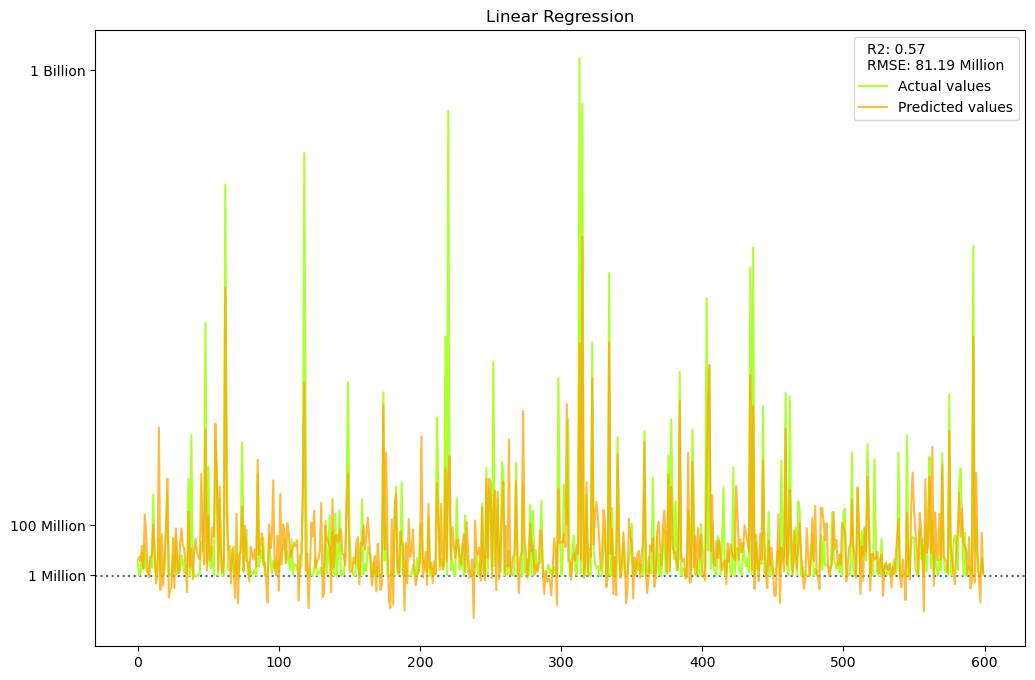

r2_score: 0.5695354702049138 
RMSE: 81194221.0858497


In [13]:
# import tools
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
#  fitting the size of the plot
plt.figure(figsize=(12, 8))
plt.title("Linear Regression")
plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])
# Draw line for 0 values
plt.axhline(y=0, linestyle='dotted')

# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="Actual values", c='greenyellow')
mse = metrics.mean_squared_error(y_test, y_prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_prediction)
# plotting the graph for predictions
plt.plot([i for i in range(len(y_test))],y_prediction, label="Predicted values", c='orange', alpha=0.75)
plt.legend(title=f"R2: {r2:.2f}\nRMSE: {(rmse/1000000):.2f} Million")
plt.show()


print( f"r2_score: {r2} \nRMSE: {rmse}")

### Show averages across 100 train test splits

In [14]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    
    RF_best = model = LinearRegression(n_jobs=None)
    RF_best.fit(X_train, y_train.ravel())
    y_pred = RF_best.predict(X_test)    
    
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.6687552682478757 RMSE: 86.18818460271397
 j = 0
R2: 0.5127339806150261 RMSE: 86.28038286807681
 j = 1
R2: 0.5030572094652912 RMSE: 80.32417546315911
 j = 2
R2: 0.6656081062775727 RMSE: 75.53911851228517
 j = 3
R2: 0.6346658971183614 RMSE: 81.39369277477245
 j = 4
R2: 0.5117878031811123 RMSE: 67.76683693270967
 j = 5
R2: 0.677578564639409 RMSE: 96.33390713543027
 j = 6
R2: 0.7251195891241993 RMSE: 78.70090511277861
 j = 7
R2: 0.6004170411483487 RMSE: 86.5408879252398
 j = 8
R2: 0.6741002817096334 RMSE: 67.75506929245589
 j = 9
R2: 0.5838849211049522 RMSE: 93.2059475570899
 j = 10
R2: 0.5878597202763274 RMSE: 83.48475095127064
 j = 11
R2: 0.7107499881335702 RMSE: 63.57423220014147
 j = 12
R2: 0.42698213898938187 RMSE: 78.96689080600575
 j = 13
R2: 0.5679226638710142 RMSE: 101.42807455335502
 j = 14
R2: 0.6226504081921664 RMSE: 88.82834639936898
 j = 15
R2: 0.7206098539367857 RMSE: 87.2037130125241
 j = 16
R2: 0.6974031724686056 RMSE: 81.83608859684664
 j = 17
R2: 0.5933358144261629